In [21]:
import polars as pl
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timezone

start_date = datetime(2023, 7, 30, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 7, 30, 23, 59, 59).replace(tzinfo=timezone.utc)

data = {"date": [],
        "system name": [],
        "variant": [],
        "CO2_raw": [],
        "CO2_compensated": [],
        "CO2_filtered": [],
        "sht45_humidity": [],
        "bme280_humidity": [],
        "bme280_pressure": [],
        "sht45_temperature": [],
        "bme280_temperature": [],
        "chamber_temperature": [],
        "gas_bottle_id": []}


def two_point_calibration(measured_values, true_values):
    # Check if input lists have length 2
    if len(measured_values) != 2 or len(true_values) != 2:
        raise ValueError("Both measured_values and true_values must have length 2")

    # Calculate calibration parameters (slope and intercept)
    # 
    slope = (true_values[1] - true_values[0]) / (measured_values[1] - measured_values[0])
    # y_true = m * y_meas + t
    intercept = true_values[0] - slope * measured_values[0]

    return slope, intercept

In [22]:
df_gas = pl.read_csv("../data/averaged_gases.csv")
df_gas.head()

Bottle_ID,CO2_dry
i64,f64
1,798.115438
2,807.238809
3,391.345476
4,399.530674
5,416.594961


In [23]:
quickflow_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/notebooks/acropolis/"
df_quickflow = pl.scan_parquet(os.path.join(quickflow_directory, "measurements.parquet")) 

In [24]:
# loop through the quickflow dataset and sort it into dataframe
df_q = df_quickflow.select(pl.col("creation_timestamp","sensor_name","value")).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

for payload in df_q.iter_rows():
    creation_timestamp = payload[0]
    sensor_name = payload[1]
    entry = json.loads(payload[2])
    
    if entry["variant"] in ("measurement","calibration"):
        # base
        data["date"].append(creation_timestamp)
        data["system name"].append(sensor_name)
        data["variant"].append(entry["variant"])
        #variant measurement & calibrtion
        data["CO2_raw"].append(entry["data"]["raw"])
        data["CO2_compensated"].append(entry["data"]["compensated"])
        data["CO2_filtered"].append(entry["data"]["compensated"])
        data["sht45_humidity"].append(entry["data"]["sht45_humidity"])
        data["bme280_humidity"].append(entry["data"]["bme280_humidity"])
        data["bme280_pressure"].append(entry["data"]["bme280_pressure"])
        data["sht45_temperature"].append(entry["data"]["sht45_temperature"])
        data["bme280_temperature"].append(entry["data"]["bme280_temperature"])
        data["chamber_temperature"].append(entry["data"]["chamber_temperature"])
        if entry["variant"] == "calibration":
                data["gas_bottle_id"].append(entry["data"]["gas_bottle_id"])
        else:
                data["gas_bottle_id"].append(None)
        
df = pl.DataFrame(data)
df.head()    

date,system name,variant,CO2_raw,CO2_compensated,CO2_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,chamber_temperature,gas_bottle_id
"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
2023-07-30 00:00:00.370 UTC,"""tum-esm-midcos…","""measurement""",362.7,396.2,396.2,58.55,58.06,941.73,22.5,22.24,23.8,null
2023-07-30 00:00:00.860 UTC,"""tum-esm-midcos…","""measurement""",386.9,421.0,421.0,63.73,62.99,943.17,21.97,21.66,23.8,null
2023-07-30 00:00:02.270 UTC,"""tum-esm-midcos…","""measurement""",393.1,432.0,432.0,57.33,55.18,933.06,22.37,22.23,23.9,null
2023-07-30 00:00:03.400 UTC,"""tum-esm-midcos…","""measurement""",389.3,425.9,425.9,59.07,60.43,931.05,22.11,22.01,23.3,null
2023-07-30 00:00:04.220 UTC,"""tum-esm-midcos…","""measurement""",394.1,430.1,430.1,58.26,58.03,938.66,22.16,21.44,23.5,null


# Picarro data

In [25]:
df_p = pd.read_csv("../data/picarro/CFADS2343-20230730-000014Z-DataLog_User.dat",sep='\s+')
df_p["datetime"] = pd.to_datetime((df_p['DATE'] + ' ' + df_p['TIME']))

# correct Picarro data
pic_slope = 1.0009341797161153 
pic_intercept = 0.32176843460007376
df_p["CO2_corr"] = df_p["CO2_dry"] * pic_slope + pic_intercept 

df_p.head()

,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,...,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,CO2_corr
0,2023-07-30,00:00:00.378,210.000004,5040.000105,211.000004,1.690675e+09,0,963,140.003001,45.00045,...,430.502855,2.022647,1181.903298,94.43908,1084.867770,76.205523,-0.074475,-0.04456,2023-07-30 00:00:00.378,431.226790
1,2023-07-30,00:00:00.884,210.000010,5040.000246,211.000010,1.690675e+09,0,963,140.000793,45.00045,...,430.574158,2.023890,1181.903298,94.43908,1084.867770,76.205523,-0.074475,-0.04456,2023-07-30 00:00:00.884,431.298160
2,2023-07-30,00:00:02.428,210.000028,5040.000675,211.000028,1.690675e+09,0,963,140.007018,45.00045,...,430.574158,2.023890,1181.910224,94.43908,1085.042196,76.205523,-0.074465,-0.04455,2023-07-30 00:00:02.428,431.298160
3,2023-07-30,00:00:03.345,210.000039,5040.000929,211.000039,1.690675e+09,0,963,140.015208,45.00045,...,430.574158,2.023890,1181.910224,94.43908,1084.920966,76.205523,-0.074471,-0.04455,2023-07-30 00:00:03.345,431.298160
4,2023-07-30,00:00:03.851,210.000045,5040.001070,211.000045,1.690675e+09,0,963,140.021429,45.00045,...,430.585300,2.023949,1181.910224,94.43908,1084.920966,76.205523,-0.074471,-0.04455,2023-07-30 00:00:03.851,431.309312


# System data

In [26]:
def avg_meas_bottle(df, bottle_id = 0):
    
    df_temp = df.filter(pl.col("gas_bottle_id") == str(bottle_id))
    
    if len(df_temp) > 60:
        df_temp = df_temp.filter(pl.col("CO2_filtered") > 0)
        avg = df_temp["CO2_filtered"][(int(len(df_temp)*0.5)):(int(len(df_temp)*0.95))].mean()
    else:
        df_temp = df_temp.filter(pl.col("CO2_filtered") > 0)
        avg = df_temp["CO2_filtered"][(int(len(df_temp)*0.3)):(int(len(df_temp)*0.95))].mean()
        
    #sns.lineplot(data=df_temp,x='date',y="CO2_compensated")
    return avg


In [27]:
def corrected_vaisala_data(df, system, bottles):
    bottles_meas = [avg_meas_bottle(df, bottle_id = bottles[0]),avg_meas_bottle(df, bottle_id = bottles[1])]
    bottles_true = [df_gas.filter(pl.col("Bottle_ID")== bottles[0])["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== bottles[1])["CO2_dry"][0]]
    
    print(bottles_meas, bottles_true)

    slope, intercept = two_point_calibration(bottles_meas, bottles_true)

    df_meas = df.filter(pl.col("variant") == "measurement").filter(pl.col("system name") == f"tum-esm-midcost-raspi-{system}")
    df_meas = df_meas.filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550)
    df_meas = df_meas.sort("date").groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())
    df_meas = df_meas.with_columns(pl.col("CO2_filtered") * slope + intercept)
    
    return df_meas

def uncorrected_vaisala_data(df, system, bottles):
    df_meas = df.filter(pl.col("variant") == "measurement").filter(pl.col("system name") == f"tum-esm-midcost-raspi-{system}")
    df_meas = df_meas.filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550)
    df_meas = df_meas.sort("date").groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())
    #df_meas = df_meas.with_columns(pl.col("CO2_filtered") * slope + intercept)
    
    return df_meas

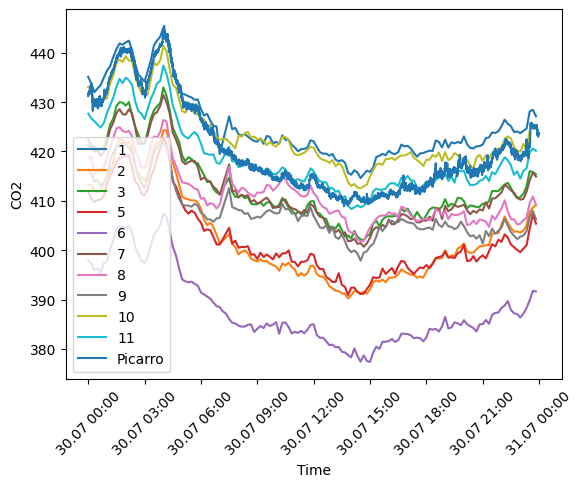

In [28]:
# uncorrected Vaisala data
sns.lineplot(data=uncorrected_vaisala_data(df, 1, [6,2]),x='date',y="CO2_filtered", label = "1")
sns.lineplot(data=uncorrected_vaisala_data(df, 2, [4,25]),x='date',y="CO2_filtered", label = "2") 
sns.lineplot(data=uncorrected_vaisala_data(df, 3, [27,14]),x='date',y="CO2_filtered", label = "3")
sns.lineplot(data=uncorrected_vaisala_data(df, 5, [22,35]),x='date',y="CO2_filtered", label = "5") 
sns.lineplot(data=uncorrected_vaisala_data(df, 6, [7,38]),x='date',y="CO2_filtered", label = "6")
sns.lineplot(data=uncorrected_vaisala_data(df, 7, [26,37]),x='date',y="CO2_filtered", label = "7") 
sns.lineplot(data=uncorrected_vaisala_data(df, 8, [30,39]),x='date',y="CO2_filtered", label = "8")
sns.lineplot(data=uncorrected_vaisala_data(df, 9, [8,33]),x='date',y="CO2_filtered", label = "9")
sns.lineplot(data=uncorrected_vaisala_data(df, 10, [36,9]),x='date',y="CO2_filtered", label = "10")
sns.lineplot(data=uncorrected_vaisala_data(df, 11, [5,34]),x='date',y="CO2_filtered", label = "11")
sns.lineplot(data=df_p,x='datetime',y="CO2_corr",label="Picarro")

# set axes labels
plt.xlabel('Time')
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

# show the plot
plt.show()

[410.4703703703706, 808.1648648648649] [401.5412941876083, 807.2388088294385]
[388.26851851851853, 776.2173913043476] [399.5306738030804, 817.9944589683803]
[396.84999999999997, 797.5333333333333] [399.57209790624563, 809.3100835262264]
[393.9370370370371, 787.6407407407406] [406.676269659521, 808.3055093557002]
[376.38918918918915, 771.0185185185185] [403.08825054200275, 814.6655503422389]
[401.0648148148149, 789.6518518518516] [403.0484176551189, 802.1964319732738]
[397.4055555555556, 804.6666666666666] [400.67101965388713, 816.2521645761756]
[405.69074074074064, 786.0740740740744] [417.4174905349762, 806.7391610200393]
[412.81481481481495, 808.9870370370371] [406.53149559549007, 805.5490240326694]
[411.2222222222222, 806.5851851851853] [416.5949607593189, 805.7284689396154]


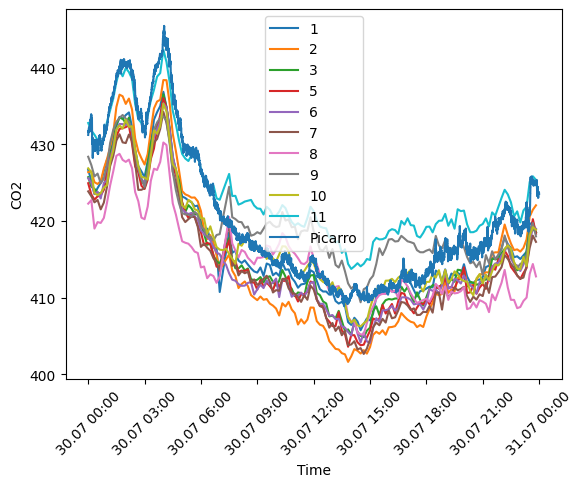

In [29]:
# corrected Vaisala data
sns.lineplot(data=corrected_vaisala_data(df, 1, [6,2]),x='date',y="CO2_filtered", label = "1")
sns.lineplot(data=corrected_vaisala_data(df, 2, [4,25]),x='date',y="CO2_filtered", label = "2") 
sns.lineplot(data=corrected_vaisala_data(df, 3, [27,14]),x='date',y="CO2_filtered", label = "3")
sns.lineplot(data=corrected_vaisala_data(df, 5, [22,35]),x='date',y="CO2_filtered", label = "5") #
sns.lineplot(data=corrected_vaisala_data(df, 6, [7,38]),x='date',y="CO2_filtered", label = "6")
sns.lineplot(data=corrected_vaisala_data(df, 7, [26,37]),x='date',y="CO2_filtered", label = "7") 
sns.lineplot(data=corrected_vaisala_data(df, 8, [30,39]),x='date',y="CO2_filtered", label = "8")
sns.lineplot(data=corrected_vaisala_data(df, 9, [8,33]),x='date',y="CO2_filtered", label = "9")
sns.lineplot(data=corrected_vaisala_data(df, 10, [36,9]),x='date',y="CO2_filtered", label = "10")
sns.lineplot(data=corrected_vaisala_data(df, 11, [5,34]),x='date',y="CO2_filtered", label = "11")
sns.lineplot(data=df_p,x='datetime',y="CO2_corr",label="Picarro")

# set axes labels
plt.xlabel('Time')
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

# show the plot
plt.show()

In [30]:
#df.filter(pl.col("variant") == "calibration").filter(pl.col("system name") == f"tum-esm-midcost-raspi-11").groupby("gas_bottle_id").head()